<a href="https://colab.research.google.com/github/hgeorge21/JSC270_A4/blob/main/JSC270_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import html

import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
try:
    nlp = spacy.load('en_core_web_sm')
except:
    msg = !python -m spacy download en_core_web_sm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_curve

import tweepy as tw

try:
  import scikitplot as skplt
except:
  !pip install scikit-plot
  import scikitplot as skplt

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Embedding, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data(train_path, test_path):
    trainD, testD = pd.read_csv(train_path, encoding='latin1'), pd.read_csv(test_path, encoding='latin1')
    trainD = trainD.drop(["Unnamed: 0"], axis=1)
    testD = testD.drop(['Unnamed: 0'], axis=1)
    return trainD, testD

trainData, testData = load_data(
    './covid-tweets-train.csv',
    './covid-tweets-test.csv')

In [3]:
# The sentiment values are off...
print(f"Unique sentiments: {trainData['Sentiment'].unique()}")

# Only 4 / 41155 rows has weird sentiment values, let's remove them
masks = False == trainData['Sentiment'].apply(lambda x: True if str(x).isdigit() else False)
print(trainData[masks])

# Remove the weird rows, reindex and convert sentiment to numeric
trainData = trainData[masks.apply(lambda x: not x)].reindex()
trainData.Sentiment = pd.to_numeric(trainData.Sentiment)

Unique sentiments: ['1' '2' '0' nan ' PA"' ' England"']
                                           OriginalTweet  Sentiment
15269  @Liberdade80 I havenÃÂt been to a supermarke...        NaN
18450  @realDonaldTrump @POTUS @RandPaul Donald J. Tr...        PA"
21383  @USAF_ACC @usairforce @ACC_Commander Can you t...        NaN
36128  @TheBlinkingOwl joined the growing list of dis...   England"


A)

In [4]:
# Show the balance of the sentiments
# 1 (neutral) is much smaller than the other two
valcounts = trainData.Sentiment.value_counts()
print(valcounts)
print("\nSentiment distribution")
print(valcounts / np.sum(valcounts))

2    18042
0    15397
1     7712
Name: Sentiment, dtype: int64

Sentiment distribution
2    0.438434
0    0.374159
1    0.187407
Name: Sentiment, dtype: float64


Processing Tweets

B & C & D & E & F

In [5]:
def preprocess(tokens):
  ret = []
  for s in tokens:
    # Remove urls
    s = re.sub(r"(http|www)\S+", "", s)
    # Remove special characters except ' to preserve words like "I'm"
    s = re.sub("[^\w\s]", "", s)
    # Change to lower cases
    s = s.lower()
    if s != "":
      ret.append(s)
  return ret

# Remove stopwords using top 100 most popular words
sw = stopwords.words('english')[:100]

def remove_stopwords(token):
  return [s for s in token if not s in sw]

In [6]:
def process_data(data):
  # Stems the words using Porter Stemmer
  stemmer = PorterStemmer()
  data['tokens'] = data['OriginalTweet'].apply(WhitespaceTokenizer().tokenize)
  data['tokens'] = data['tokens'].apply(preprocess)
  data['tokens'] = data['tokens'].apply(lambda x: [stemmer.stem(t) for t in x])
  data['tokens'] = data['tokens'].apply(remove_stopwords)
  return data

In [7]:
trainD = process_data(trainData)
testD = process_data(testData)

X_train, y_train = trainD['tokens'].to_numpy(), trainD['Sentiment'].to_numpy()
X_test, y_test = testD['tokens'].to_numpy(), testD['Sentiment'].to_numpy()

n_train, n_test = X_train.shape[0], X_test.shape[0]
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

G)

In [8]:
vocab = np.unique(np.concatenate(X))
vocab_count = vocab.shape[0]
print(f"Vocab size: {vocab_count}")

def override_fcn(doc):
  # We expect a list of tokens as input
  return doc

# Count Vectorizer
count_vec = CountVectorizer(
    analyzer='word',
    tokenizer=override_fcn,
    preprocessor=override_fcn,
    token_pattern=None,
    max_features=vocab_count)

Vocab size: 55423


In [9]:
# Remember this output is a Scipy Sparse Array
# Store separately since dense ones still needed
X_trans = count_vec.fit_transform(X)
X_trainS, X_testS = X_trans[:n_train, :], X_trans[n_train:, :]

H)

In [10]:
# Fit a Naive Bayes model on this
nb = MultinomialNB()
nb.fit(X_trainS, y_train)

y_pred_train = nb.predict(X_trainS)
y_pred_test  = nb.predict(X_testS)
print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"Train error:    {1-accuracy_score(y_train, y_pred_train):.2f}")
print(f"Test accuracy:  {accuracy_score(y_test, y_pred_test):.2f}")
print(f"Test error:     {1-accuracy_score(y_test, y_pred_test):.2f}")

Train accuracy: 0.79
Train error:    0.21
Test accuracy:  0.68
Test error:     0.32


In [11]:
# Get the top 5 words for each sentiment, looks reasonable
for k in [0, 1, 2]:
  mask = y_train == k
  text = X_train[mask]
  unique, counts = np.unique(np.concatenate(text), return_counts=True)
  prob = (counts+1) / np.sum(counts+1)
  idx = prob.argsort()[-5:][::-1]
  print(f"Sentiment {k}: {unique[idx]}")
  print(f"Counts {k}:    {counts[idx]}")

Sentiment 0: ['coronaviru' 'covid19' 'price' 'food' 'thi']
Counts 0:    [6703 4862 4332 3622 3206]
Sentiment 1: ['coronaviru' 'covid19' 'store' 'supermarket' 'price']
Counts 1:    [3792 2751 1581 1435 1361]
Sentiment 2: ['coronaviru' 'covid19' 'store' 'thi' 'price']
Counts 2:    [7466 6001 3895 3770 3322]


I)

ROC curve is appropriate because the count of each class is balanced. In a inbalanced class distribution, the ROC curve does not give much information since the AUC will be very high. In this case, the three classes (0, 1, 2) are 44%, 37%, 19% of total data, respectively. So the classfication does not favor any particular class and thus ROC curve is applicable in this case.

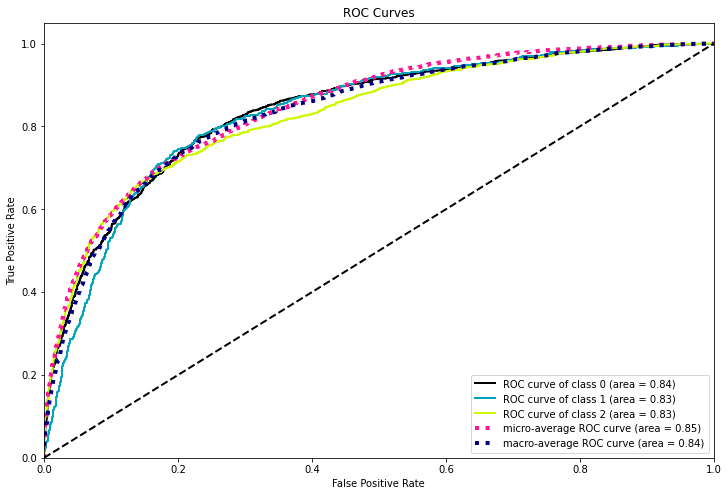

In [12]:
y_probas = nb.predict_proba(X_testS)

fig, ax = plt.subplots(figsize=(12,8))
skplt.metrics.plot_roc(y_test, y_probas, ax=ax)
plt.show()

J)

In [13]:
def TF_IDF_predict(X, y, n_train):
    vocab = np.unique(np.concatenate(X))
    vocab_count = vocab.shape[0]

    def override_fcn(doc):
      # We expect a list of tokens as input
      return doc

    tfidf =  TfidfVectorizer(analyzer='word',
                             tokenizer=override_fcn,
                             preprocessor=override_fcn,
                             token_pattern=None,
                             max_features=vocab_count)
    tfs = tfidf.fit_transform(X)
    X_train_tfs, X_test_tfs = tfs[:n_train, :], tfs[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    
    nb = MultinomialNB()
    nb.fit(X_train_tfs, y_train)
    y_pred_train = nb.predict(X_train_tfs)
    y_pred_test  = nb.predict(X_test_tfs) 

    print(f"Train accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Train error:    {1-accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Test accuracy:  {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"Test error:     {1-accuracy_score(y_test, y_pred_test):.2f}")
    
TF_IDF_predict(X, y, n_train)

Train accuracy: 0.72
Train error:    0.28
Test accuracy:  0.64
Test error:     0.36


K)

In [14]:
def process_data_lemmatizer(data):
  # lemmatizes the words using WordNet lemmatizer
  lemmatizer = WordNetLemmatizer()
  data['tokens'] = data['OriginalTweet'].apply(WhitespaceTokenizer().tokenize)
  data['tokens'] = data['tokens'].apply(preprocess)
  data['tokens'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
  data['tokens'] = data['tokens'].apply(remove_stopwords)
  return data

In [15]:
trainD = process_data_lemmatizer(trainData)
testD = process_data_lemmatizer(testData)

X_train, y_train = trainD['tokens'].to_numpy(), trainD['Sentiment'].to_numpy()
X_test, y_test = testD['tokens'].to_numpy(), testD['Sentiment'].to_numpy()

n_train, n_test = X_train.shape[0], X_test.shape[0]
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

TF_IDF_predict(X, y, n_train)

Train accuracy: 0.73
Train error:    0.27
Test accuracy:  0.64
Test error:     0.36


Part 2

In [16]:
api_key = 'geVceEjNp9C83wY1qbY5GBXLv'
api_secret_key = 'T3UwzQ2qSTeNTNtS5qv0E9hVLYBPeIaQVWhVa1K34Zd19BvQw8'
access_key =  '1369267084820160514-TCwE5D6ofbjHEL7E2vPOvVyIg1KnOV'
access_secret = 'AecNVigHnt6iV8YEXZWpAnOckplm9xW6Hvoaa2MkAjUBq'

In [17]:
# Use credentials to authorize access
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_key, access_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [18]:
# WARNING!!!
# if you run this commented section, it will take A LONG TIME (10 hours for me)
# Below is to load saved data from memory
# search_words = 'lockdown'
# date_since = "2021-03-09"
# # We can add filters to our search words 
# search_with_filter = search_words + " -filter:retweets"

# tweets = tw.Cursor(api.search,
#                     q=search_with_filter,
#                     lang="en",
#                     since=date_since,
#                     result_type = 'recent').items(100000)
# # Could also specify popular
# print('done gathering')
# ls = [tweet.text for tweet in tweets]
# print(len(ls))
# df = pd.DataFrame(ls, columns=['tweets'])
# df.to_pickle('tweetsData')

# If you want to load from pickle
# !pip install pickle5
# import pickle5
# with open('tweetsData', 'rb') as f:
#   df = pickle5.load(f)

# If you want to load from csv
df = pd.read_csv('tweetData.csv')

In [19]:
def preprocess2(tokens):
  ret = []
  for s in tokens:
    # Remove urls
    s = re.sub(r"(http|www)\S+", "", s)
    # Remove usernames
    s = re.sub("@.+", "", s)
    # Remove special characters except ' to preserve words like "I'm"
    s = re.sub("[^\w\s']", "", s)
    # Change to lower cases
    s = s.lower()
    if s != "":
      ret.append(s)
  return ret

def process_data2(data):
    lemmatizer = WordNetLemmatizer()
    data['tokens'] = data['tweets'].apply(WhitespaceTokenizer().tokenize)
    data['tokens'] = data['tokens'].apply(preprocess2)
    data['tokens'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
    return data

df = process_data2(df)
df.head(10)

,tweets,tokens
0,Covid: Croquet clubs 'inundated' during lockdo...,"[covid, croquet, club, 'inundated', during, lo..."
1,Lockdown Madness In Cebu City 4/4/21 https://t...,"[lockdown, madness, in, cebu, city, 4421, via]"
2,@dhanushkraja Everyone is talking about Lockdo...,"[everyone, is, talking, about, lockdown, from,..."
3,'The zebras loved lockdown but the goats misse...,"['the, zebra, loved, lockdown, but, the, goat,..."
4,#FMCG companies getting ready in anticipation ...,"[fmcg, company, getting, ready, in, anticipati..."
5,Corona Report from Medical officer/ DM has not...,"[corona, report, from, medical, officer, dm, h..."
6,#Lockdown in #bangladesh \nFor 1 week. https:/...,"[lockdown, in, bangladesh, for, 1, week]"
7,I am rewatchint the Amy's Baking Company episo...,"[i, am, rewatchint, the, amy's, baking, compan..."
8,When people &amp; Business owners r ready to p...,"[when, people, amp, business, owner, r, ready,..."
9,🚨🚨🚨MINGYU LOCKDOWN TOMORROW🚨🚨🚨🚨🚨🚨🚨,"[mingyu, lockdown, tomorrow]"


In [20]:
data = df['tokens']
lens = data.apply(lambda x: len(x))
maxlen = max(lens)
data = data[lens > 5]
del lens

In [21]:
tt = []
for d in data:
  sent = ''
  for word in d:
    sent = sent + word + ' '
  sent = sent[:-1]
  tt.append(sent)
del data

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tt)
sequences = tokenizer.texts_to_sequences(tt)
vocab_size = len(tokenizer.word_index) + 1
del tt

vocab_size

53916

In [23]:
from keras.preprocessing import sequence 
sequences = sequence.pad_sequences(sequences, maxlen=maxlen) 

# for data in train_data:
input_len = 15
new_seqs = [] 
for seq in sequences:
  for i in range(len(seq) - (input_len+1)):
    new_seqs.append(seq[i:i+input_len+1])
new_seqs = np.array(new_seqs)

In [24]:
# Get only valid data
new_seqs = new_seqs[new_seqs[:,-1]>0,:]
X, y = new_seqs[:,:input_len], new_seqs[:,input_len]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X.shape, y.shape

((1254048, 15), (1254048,))

In [26]:
def buildmodel(vocab_size, embed_size, input_len):
  model = Sequential()
  model.add(Embedding(vocab_size, embed_size, input_length=input_len))
  model.add(Bidirectional(LSTM(100, return_sequences=True, go_backwards=True)))
  model.add(LSTM(100))
  model.add(Dense(100, activation="relu"))
  model.add(Dense(vocab_size, activation="softmax"))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("model{epoch:003d}.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

model = buildmodel(vocab_size, 20, input_len)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 20)            1078320   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 200)           96800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 53916)             5445516   
Total params: 6,751,136
Trainable params: 6,751,136
Non-trainable params: 0
_________________________________________________________________


In [28]:
hist = model.fit(X_train, y_train, 
                 epochs=30, batch_size=256, #validation_split=0.2, shuffle=True,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/30
3919/3919 [==============================] - 153s 37ms/step - loss: 7.1801 - accuracy: 0.0426 - val_loss: 6.7482 - val_accuracy: 0.0515

Epoch 00001: loss improved from inf to 6.99634, saving model to model001.hdf5
Epoch 2/30
3919/3919 [==============================] - 145s 37ms/step - loss: 6.4874 - accuracy: 0.0730 - val_loss: 6.1423 - val_accuracy: 0.1201

Epoch 00002: loss improved from 6.99634 to 6.32523, saving model to model002.hdf5
Epoch 3/30
3919/3919 [==============================] - 145s 37ms/step - loss: 5.9060 - accuracy: 0.1269 - val_loss: 5.9569 - val_accuracy: 0.1396

Epoch 00003: loss improved from 6.32523 to 5.86254, saving model to model003.hdf5
Epoch 4/30
3919/3919 [==============================] - 143s 36ms/step - loss: 5.6360 - accuracy: 0.1461 - val_loss: 5.8749 - val_accuracy: 0.1546

Epoch 00004: loss improved from 5.86254 to 5.61301, saving model to model004.hdf5
Epoch 5/30
3919/3919 [==============================] - 143s 36ms/step - loss: 5.436

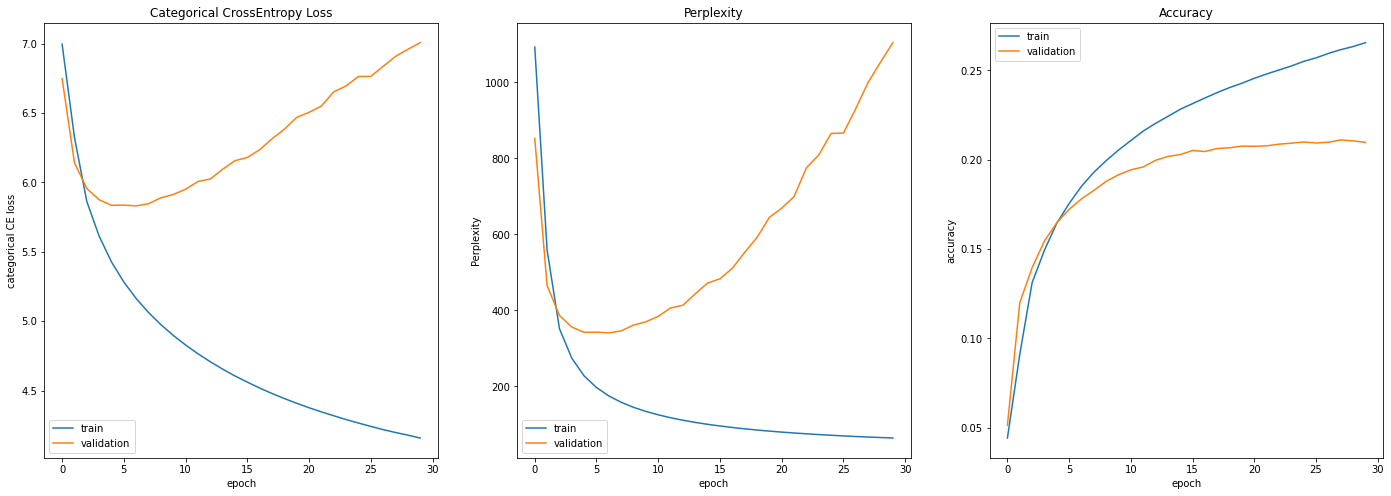

In [29]:
train_losses = hist.history['loss']
valid_losses = hist.history['val_loss']
perplexity_train = np.exp(train_losses)
perplexity_valid = np.exp(valid_losses)
train_accur = hist.history['accuracy']
valid_accur = hist.history['val_accuracy']

fig, axs = plt.subplots(1,3,figsize=(24,8))
# Plot CE loss
axs[0].set(title='Categorical CrossEntropy Loss', xlabel='epoch', ylabel='categorical CE loss')
axs[0].plot(hist.epoch, train_losses, label='train')
axs[0].plot(hist.epoch, valid_losses, label='validation')
axs[0].legend()
# Plot perplexicity
axs[1].set(title='Perplexity', xlabel='epoch', ylabel='Perplexity')
axs[1].plot(hist.epoch, perplexity_train, label='train')
axs[1].plot(hist.epoch, perplexity_valid, label='validation')
axs[1].legend()
# Plot accuracy
axs[2].set(title='Accuracy', xlabel='epoch', ylabel='accuracy')
axs[2].plot(hist.epoch, train_accur, label='train')
axs[2].plot(hist.epoch, valid_accur, label='validation')
axs[2].legend()
plt.show()

In [30]:
# Conduct test on final model after 30 epochs
model.evaluate(X_test, y_test)

7838/7838 [==============================] - 82s 10ms/step - loss: 7.0069 - accuracy: 0.2098


[7.006875038146973, 0.209760382771492]

In [32]:
# Load specific model to test, look at model at epoch 12 since it is not over-fit too badly yet
from keras.models import load_model
model1 = load_model('model012.hdf5')
model1.evaluate(X_test, y_test)

7838/7838 [==============================] - 84s 11ms/step - loss: 6.0067 - accuracy: 0.1960


[6.006707191467285, 0.1960049420595169]